In [1]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np

PHASE2_DIR = MAIN_DIR / "archive" / "phase2_bbob"

In [2]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[3:6]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        db._conn.close()
        db_path.unlink()
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    # if cost.max() >= 100:
        # print(f"Test cut-off {db_path}")
    cut_off_ratio = (cost >= 100).mean()
    cost.loc[cost >= 100] = 100
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cut_off_ratio": cut_off_ratio,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/123 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cut_off_ratio,cpu_time,surrogate_pct,real_pct
0,run-policy-bbob-baseline--25-1129015.db,25,baseline,,20.552887,0.166667,6.473403,0.00000,1.000000
1,run-policy-bbob-baseline--25-1129023.db,25,baseline,,23.321004,0.200000,6.315510,0.00000,1.000000
2,run-policy-bbob-baseline--25-1129029.db,25,baseline,,22.450362,0.187500,6.156015,0.00000,1.000000
3,run-policy-bbob-baseline--25-1129263.db,25,baseline,,22.316469,0.183333,7.819009,0.00000,1.000000
4,run-policy-bbob-baseline--25-1129269.db,25,baseline,,21.706169,0.187500,6.614892,0.00000,1.000000
...,...,...,...,...,...,...,...,...,...
118,run-policy-bbob-ib--25-1129280.db,25,ib,,20.458944,0.158333,2.102348,0.97449,0.280612
119,run-policy-bbob-ib--25-1129286.db,25,ib,,19.897140,0.158333,1.106329,0.97449,0.147959
120,run-policy-bbob-ib--25-1129634.db,25,ib,,19.634516,0.162500,2.551943,0.97449,0.331633
121,run-policy-bbob-ib--25-1129640.db,25,ib,,27.213092,0.245833,1.943227,0.97449,0.301020


In [3]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        25
policy   parg    
baseline       10
ea       25     8
         50    10
         75     8
eb       25     8
         50    10
         75     8
ec       100   10
         50     8
         75     7
ia       1+1   10
         1+2    8
         2+1    8
ib             10

In [7]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cut_off_ratio=("cut_off_ratio", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cut_off_ratio = df_agg.at[("baseline", ""), "cut_off_ratio"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / baseline_cost
    df_agg["cut_off_ratio_ratio_to_baseline"] = df_agg["cut_off_ratio"] / baseline_cut_off_ratio
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / baseline_cpu_time
    df_agg["alpha"] = baseline_cost / df_agg["cost"]
    df_agg["beta"] = (baseline_cpu_time - df_agg["cpu_time"]) * 3600 / df_agg["cost"]
    df_agg["better_than_baseline_until"] = np.floor(df_agg["beta"] / (1 - df_agg["alpha"])) + 1
    df_agg.loc[df_agg["beta"] < 0, "better_than_baseline_until"] = np.nan

    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cut_off_ratio", "cut_off_ratio_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct", "alpha", "beta", "better_than_baseline_until"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
df100 = df.loc[df["n_train"] == "100"].copy()
df250 = df.loc[df["n_train"] == "250"].copy()

df25_agg = agg(df25)
# df100_agg = agg(df100)
# df250_agg = agg(df250)

In [8]:
df25_agg

cost  cost_ratio_to_baseline  cut_off_ratio  \
policy   parg                                                   
baseline       21.4844                  1.0000         0.1779   
ea       25    21.9716                  1.0227         0.1839   
         50    21.1348                  0.9837         0.1708   
         75    21.9398                  1.0212         0.1797   
eb       75    22.2104                  1.0338         0.1844   
         50    24.2258                  1.1276         0.2096   
         25    23.1248                  1.0764         0.1932   
ec       100   21.4953                  1.0005         0.1800   
         75    22.3574                  1.0406         0.1839   
         50    22.8749                  1.0647         0.1932   
ia       1+2   21.8631                  1.0176         0.1818   
         1+1   21.9510                  1.0217         0.1833   
         2+1   21.1570                  0.9848         0.1755   
ib             22.0632                  1.0269         0.1858   

               cut_off_ratio_ratio_to_baseline  cpu_time  \
policy   parg                                              
baseline                                1.0000    7.0589   
ea       25                             1.0334    5.3101   
         50                             0.9602    3.6943   
         75                             1.0100    2.0079   
eb       75                             1.0363    3.3123   
         50                             1.1780    1.9296   
         25                             1.0861    0.8583   
ec       100                            1.0117   13.4405   
         75                             1.0338   10.3810   
         50                             1.0861    7.4608   
ia       1+2                            1.0217    4.7824   
         1+1                            1.0304    3.6696   
         2+1                            0.9865    2.4920   
ib                                      1.0445    1.7912   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct   alpha  \
policy   parg                                                                
baseline                           1.0000         0.0000    1.0000  1.0000   
ea       25                        0.7523         0.2465    0.7559  0.9778   
         50                        0.5234         0.4896    0.5156  1.0165   
         75                        0.2844         0.7296    0.2786  0.9792   
eb       75                        0.4692         0.9745    0.7686  0.9673   
         50                        0.2734         0.9745    0.5371  0.8868   
         25                        0.1216         0.9745    0.3057  0.9291   
ec       100                       1.9040         0.9745    1.0000  0.9995   
         75                        1.4706         0.9745    1.0000  0.9610   
         50                        1.0569         0.9745    1.0000  0.9392   
ia       1+2                       0.6775         0.3265    0.6741  0.9827   
         1+1                       0.5199         0.4898    0.5122  0.9787   
         2+1                       0.3530         0.6531    0.3527  1.0155   
ib                                 0.2538         0.9745    0.2541  0.9738   

                    beta  better_than_baseline_until  
policy   parg                                         
baseline          0.0000                         NaN  
ea       25     286.5438                     12921.0  
         50     573.1063                    -34651.0  
         75     828.8020                     39923.0  
eb       75     607.2689                     18578.0  
         50     762.2288                      6736.0  
         25     965.2950                     13608.0  
ec       100  -1068.7809                         NaN  
         75    -534.9300                         NaN  
         50     -63.2473                         NaN  
ia       1+2    374.8441                     21638.0  
         1+1    555.8576                     26151.0

In [14]:
# df250_agg.to_excel("tmp.xlsx")

In [15]:
# df.loc[(df["policy"] == "ib") & (df["parg"] == "") & (df["n_train"] == "250")].sort_values(by="cost")

In [16]:
# db = DB(PHASE2_DIR / "run-policy-ib--100-1016238.db")

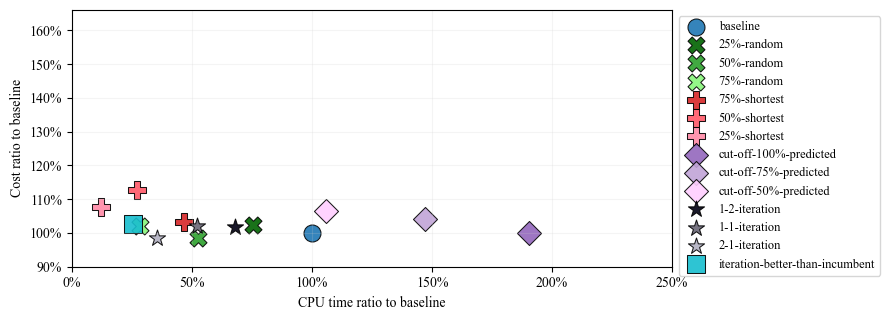

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#006300",
    ("ea", "50"): "#2ca02c",
    ("ea", "75"): "#89f57b",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#010013", 
    ("ia", "1+1"): "#696676",
    ("ia", "2+1"): "#b1afc0",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-random",
    ("ea", "50"): "50%-random",
    ("ea", "75"): "75%-random",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "s",
}

def plot_cost_vs_cpu_time_ratio(df, df_agg, plot_all=False):
    fig, ax = plt.subplots(figsize=(9, 3.3))

    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]

    for (policy, parg), row in df_agg.iterrows():
        if plot_all:
            _ = df.loc[(df["policy"] == policy) & (df["parg"] == parg)]
            plt.scatter(
                _["cpu_time"] / baseline_cpu_time,
                _["cost"] / baseline_cost,
                s=20,
                alpha=0.9,
                color=COLORS[(policy, parg)],
                marker=MARKERS[policy],
                linewidths=0.5,
                edgecolor="black",
            )
        plt.scatter(
            row["cpu_time_ratio_to_baseline"],
            row["cost_ratio_to_baseline"],
            s=150,
            alpha=0.9,
            color=COLORS[(policy, parg)],
            marker=MARKERS[policy],
            linewidths=0.75,
            edgecolor="black",
            label=LABELS[(policy, parg)],
        )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
    plt.xlabel("CPU time ratio to baseline")
    plt.ylabel("Cost ratio to baseline")
    if not plot_all:
        plt.xlim(0, 2.5)
        plt.ylim(0.9, 1.66)
    # plt.title("Cost ratio vs. CPU time ratio")
    plt.tight_layout()
    return fig, ax

fig, ax = plot_cost_vs_cpu_time_ratio(df25, df25_agg, plot_all=False)
# fig, ax = plot_cost_vs_cpu_time_ratio(df100, df100_agg, plot_all=True)
# fig, ax = plot_cost_vs_cpu_time_ratio(df250, df250_agg, plot_all=True)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
# plt.savefig("cpu_vs_cost.pdf", bbox_inches="tight")
plt.show()

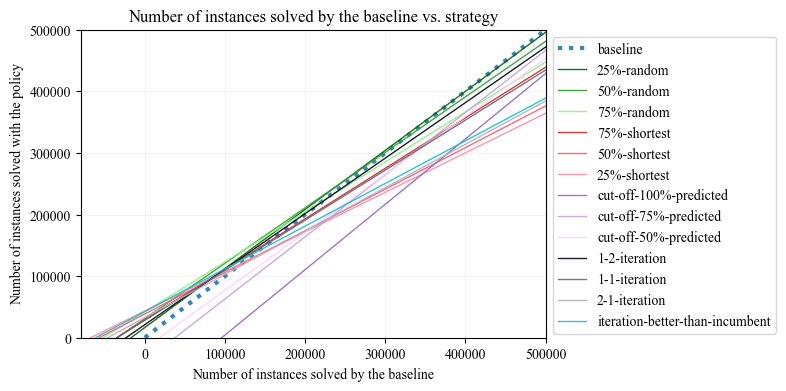

In [10]:
def plot_lines(df_agg, lim):
    fig, ax = plt.subplots(figsize=(6, 4))

    for (policy, parg), row in df_agg.iterrows():
        cost = row["cost"]
        cpu_time = row["cpu_time"]
        ax.axline(
            (0, row["beta"]),
            slope=row["alpha"],
            alpha=0.9,
            color=COLORS[(policy, parg)],
            lw=1 if policy != "baseline" else 3,
            ls="-" if policy != "baseline" else "dotted",
            label=LABELS[(policy, parg)],
        )

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("Number of instances solved by the baseline")
    plt.ylabel("Number of instances solved with the policy")
    plt.xlim(-80000, lim)
    plt.ylim(0, lim)
    plt.title("Number of instances solved by the baseline vs. strategy")
    return fig, ax

fig, ax = plot_lines(df25_agg, 500000)
# fig, ax = plot_lines(df100_agg, 1000000)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

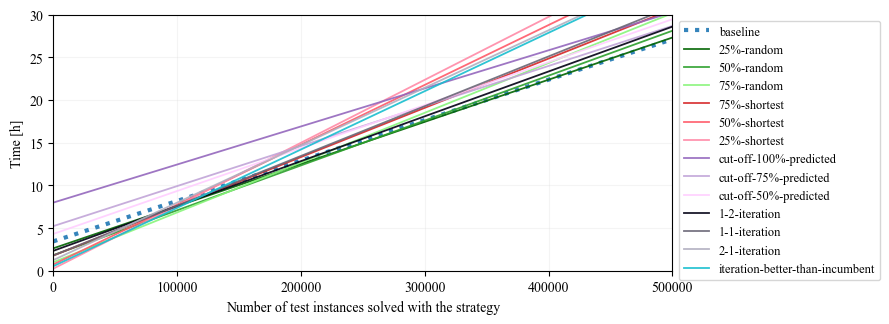

In [24]:
fig, ax = plt.subplots(figsize=(9, 3.35))

for (policy, parg), row in df25_agg.iterrows():
    alpha = row["cost"] / 3600
    beta = row["cpu_time"]
    ax.axline(
        (0, beta),
        slope=alpha,
        alpha=0.9,
        color=COLORS[(policy, parg)],
        lw=1.3 if policy != "baseline" else 3,
        ls="-" if policy != "baseline" else "dotted",
        label=LABELS[(policy, parg)],
    )

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=9)
plt.ylabel("Time [h]")
plt.xlabel("Number of test instances solved with the strategy")
plt.xlim(0, 500000)
plt.ylim(0, 30)
plt.tight_layout()
plt.savefig("simulation.pdf", bbox_inches="tight")
plt.show()

In [112]:
_ = pd.DataFrame(index=np.linspace(1, 2000000, 2000000).astype(int))

for (policy, parg), row in df25_agg.iterrows():
    alpha = row["cost"] / 3600
    beta = row["cpu_time"]
    label = LABELS[(policy, parg)]
    _[label] = _.index * alpha + beta
    
_["strategy"] = _.idxmin(axis=1)
_

,baseline,25%-random,50%-random,75%-random,75%-shortest,50%-shortest,25%-shortest,cut-off-100%-predicted,cut-off-75%-predicted,cut-off-50%-predicted,1-2-iteration,1-1-iteration,2-1-iteration,iteration-better-than-incumbent,strategy
1,3.436447,2.621249,1.817853,0.989858,1.770958,0.732170,0.235674,7.975645,5.220247,4.305550,2.328452,1.781158,1.242067,0.525168,25%-shortest
2,3.436495,2.621299,1.817905,0.989917,1.771015,0.732240,0.235747,7.975689,5.220294,4.305601,2.328505,1.781217,1.242135,0.525237,25%-shortest
3,3.436542,2.621348,1.817958,0.989975,1.771073,0.732310,0.235821,7.975734,5.220341,4.305651,2.328557,1.781275,1.242202,0.525305,25%-shortest
4,3.436589,2.621397,1.818010,0.990033,1.771131,0.732380,0.235895,7.975778,5.220388,4.305701,2.328610,1.781333,1.242269,0.525373,25%-shortest
5,3.436637,2.621447,1.818063,0.990092,1.771188,0.732450,0.235969,7.975823,5.220434,4.305751,2.328662,1.781391,1.242336,0.525442,25%-shortest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999996,98.102877,101.343225,106.928701,117.656233,117.104003,140.898486,147.679750,97.142088,98.997790,104.860854,107.328190,118.336422,135.797286,137.191493,cut-off-100%-predicted
1999997,98.102925,101.343274,106.928753,117.656292,117.104060,140.898556,147.679823,97.142133,98.997837,104.860905,107.328243,118.336481,135.797354,137.191562,cut-off-100%-predicted
1999998,98.102972,101.343324,106.928806,117.656350,117.104118,140.898627,147.679897,97.142178,98.997884,104.860955,107.328295,118.336539,135.797421,137.191630,cut-off-100%-predicted
1999999,98.103019,101.343373,106.928859,117.656408,117.104176,140.898697,147.679971,97.142222,98.997931,104.861005,107.328348,118.336597,135.797488,137.191698,cut-off-100%-predicted


In [121]:
print(_.reset_index().groupby("strategy").agg(from_problem_count=("index", "min"), to_problem_count=("index", "max")).sort_values(by="from_problem_count").reset_index().style.to_latex())

\begin{tabular}{llrr}
 & strategy & from_problem_count & to_problem_count \\
0 & 25%-shortest & 1 & 49009 \\
1 & 75%-random & 49010 & 143307 \\
2 & 50%-random & 143308 & 251499 \\
3 & 25%-random & 251500 & 402016 \\
4 & baseline & 402017 & 1650618 \\
5 & cut-off-100%-predicted & 1650619 & 2000000 \\
\end{tabular}

